In [1]:
pip install openpyxl


[notice] A new release of pip available: 22.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
import os
os.sys.path.append(os.path.join('..',''))
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from utils import encode, resize
pd.options.display.max_colwidth = 100
sep = '|'
random_state = 42

In [88]:
def SpRank(X, y):
    X2 = {x : i for i,x in enumerate(sorted(X))}
    y2 = {x : i for i,x in enumerate(sorted(y))}
    df = pd.DataFrame({'X' : X, 'y' : y})
    df['X_rank'] = df['X'].apply(X2.__getitem__)
    df['y_rank'] = df['y'].apply(y2.__getitem__)
    return df[['X_rank', 'y_rank']].corr()['y_rank'].values[0]

def getMeanErrorStats(y_observed, y_predicted, samples = 10, sample_elements = 50):
    sample_diffs = []
    for _ in range(samples):
        sample_indicies = [np.random.randint(0,len(y_observed)) for __ in range(sample_elements)]
        y_test1 = y_predicted[sample_indicies]
        y_test2 = y_observed[sample_indicies]
        sample_diffs.append((np.mean(y_test1) - np.mean(y_test2))/np.mean(y_test2))
    mn = np.mean(sample_diffs)
    sd = np.std(sample_diffs)
    mn = max(mn, abs(np.mean(y_observed) - np.mean(y_predicted))/np.mean(y_observed))
    return mn, sd

def dropUnbalancedColumns(df):
    columns_to_drop = []
    for col in df:
        uns = df[col].unique()
        if len(uns) == 2:
            cnts = df[col].value_counts()
            if max(cnts[uns[0]], cnts[uns[1]])/min(cnts[uns[0]], cnts[uns[1]]) > 10:
                columns_to_drop.append(col)
    df = df.drop(columns = columns_to_drop)
    return df

def filterDict(scs, min_corr_th):
    mn = np.mean([abs(x) for x in scs.values() if not np.isnan(x)])
    sd = np.std([abs(x) for x in scs.values() if not np.isnan(x)])
    scs = {col : scs[col] for col in scs if abs(scs[col]) > (mn+3*sd) or scs[col] > min_corr_th}
    return scs

def makeDecompositionDf(df, mode = None, min_corr_th = .3):
    if mode is None:
        mode = PCA()
    model = mode
    col_names = str(model.__class__).split('.')[-1].split("'")[0]
    df_decomp_cols = [x for x in df if not 'hope' in x.lower()]
    df_decomp = model.fit_transform(StandardScaler().fit_transform(df[df_decomp_cols]))
    df_decomp[df_decomp > 4] = 4
    df_decomp[df_decomp < -4] = -4
    df_decomp = pd.DataFrame({col_names + str(i): df_decomp[:,i] for i in range(df_decomp.shape[1])})
    
    scs = {col : SpRank(df_decomp[col].values, df['Hope Scale Score'].values) for col in df_decomp}
    scs2nd_order = {'@'.join([col1, col2]): SpRank((df_decomp[col1]*df_decomp[col2]).values, 
                                                  df['Hope Scale Score'].values)  
                    for i,col1 in enumerate(df_decomp.columns) for col2 in df_decomp.columns[i:]}
    scs2nd_orderv2 = {'@'.join([col2, col1]): SpRank((df_decomp[col2] + df_decomp[col2].min())/(df_decomp[col1] + df_decomp[col1].min()+.01).fillna(0).values, 
                                                  df['Hope Scale Score'].values)  
                    for i,col1 in enumerate(df_decomp.columns[:(len(df_decomp.columns)-1)]) for col2 in df_decomp.columns[(i+1):]}
    scs = filterDict(scs, min_corr_th)
    scs2nd_order = filterDict(scs2nd_order,  min_corr_th)
    scs2nd_orderv2 = filterDict(scs2nd_orderv2,  min_corr_th)
    return df_decomp, scs, scs2nd_order, scs2nd_orderv2

In [6]:
with open(os.path.join("..", "Data", "Encodings_2022.dat"), 'rb') as f:
    encodings = pickle.load(f)
with open(os.path.join("..", "Data", "DroppableColumns.dat"), 'rb') as f:
    droppable = pickle.load(f)
encodings['No@Yes'] = {'Yes' : 1.0, 'No' : 0.0}
encodings['Not Seeking@Seeking'] = {'Seeking' : 1.0, 'Not Seeking' : 0.0}

In [7]:
survey_root = os.path.join("..", "..", "raw_csv")
survey_csv = "2022_Annual_Survey_Aggregate_Data_for_2022_Annual_Survey_20220905222712-SurveyExport.csv"
survey_path = os.path.join(survey_root, survey_csv)
df_orig = pd.read_csv(survey_path, sep = sep)
for x in df_orig:
    if df_orig[x].isna().sum() == len(df_orig):
        df_orig.drop(columns = x)

df_orig = df_orig[df_orig.apply(lambda x : sum([pd.isna(y) for y in x])/len(x) < 0.5, axis = 1)]
df_orig = df_orig[~df_orig['Hope Scale Score'].isna()]
df_orig = df_orig.drop(columns = droppable)
is_military = df_orig['Are you, or were you ever, an active member of the military or member of the National Guard or Reserve?'] == 'Yes'
df_orig_military = df_orig[is_military]
df_orig_civ = df_orig[~is_military]

# Data Cleaning

In [85]:
df = df_orig_military.copy()

replacements_dictionary = {'Yes' : 1,
                          'No' : 0,
                          "I don't know/unsure" : 0.5,
                           'Prefer not to respond' : 0.5,
                           'Unknown' : 0.5,
                           'Unsure' : 0.5,
                          'Seeking' : 1,
                          'Not Seeking': 0}
feet_col = 'Feet:'
inch_col = 'Inches:'
srvc_start_col = "What year did you begin your time in the service? (Ex: 1985)"
srvc_end_col = "What year did your status become retired/discharged? (Ex: 2006)"
non_question_columns = {"Response ID", "Time Started", "Date Submitted", 
                        "Status", "Language", "Referer", "SessionID",
                       "Legacy Comments", "Comments", "User Agent", "Tags", 
                        "Contact Information- Non Military Connected",
                       "What is your zip code?"}
non_question_columns = ['Response ID',
 'Time Started',
 'Date Submitted',
 'Status',
 'Language',
 'Referer',
 'SessionID',
 'What is your zip code?',
                       "Time Started"]
#df = df.fillna(-1)
# question_columns = [x for x in df if not x in non_question_columns and not x in droppableColumns]

question_columns = [x for x in df if not x in non_question_columns]

df = df[question_columns]
df['Service Start Decade'] = df[srvc_start_col].apply(round, args = [-1])
df[feet_col] = df[feet_col].apply(lambda x : np.nan if isinstance(x, str) else x).astype(float)
df[feet_col] = df[feet_col].apply(lambda x: np.nan if x<4 or x > 6 else x)
df[inch_col] = df[inch_col].apply(lambda x: np.nan if isinstance(x, str) else x).astype(float)
df[inch_col] = df[inch_col].apply(lambda x: np.nan if x<0 or x > 12 else x)
df['Height In Inches'] = (12 * df[feet_col] + df[inch_col]).copy()
df[srvc_end_col] = df[srvc_end_col].apply(lambda x : np.nan if isinstance(x, str) else x).astype(float)
df[srvc_start_col] = df[srvc_start_col].apply(lambda x: np.nan if isinstance(x, str) else x).astype(float)
df['Years Of Service'] = (df[srvc_end_col] - df[srvc_start_col]).apply(lambda x : np.nan if x < 0 else x)
df['Length Of Service In Decades'] = df['Years Of Service']//10
df['BMI'] = (df['What is your current weight? (in pounds)Â\xa0']/(df['Height In Inches']/39.3701)**2)
df = df.drop(columns = [feet_col, inch_col, srvc_end_col])
df['IsMinority?'] = df['Race:Â\xa0'] == 'White American'
df = encode(df, encodings)
droppableColumns = ['Race:Â\xa0', 
                    'You have indicated that you have a form of healthcare coverage as well as you have untreated medical conditions. What prevents you from receiving treatment for your medical conditions? Â\xa0']
for col in df:
    num_na = df[col].isna().sum()
    if (num_na > 1 and df[col].dropna().nunique() == 1) or num_na > len(df) * (.8):
        df[col] = df[col].isna()
        continue
    if num_na == len(df) or df[col].dropna().nunique() == 1:
        droppableColumns.append(col)
        continue

df = df.drop(columns = droppableColumns)
df = encode(df, encodings)

encodable_cols = []
cols_to_fill = []
for col in df:
    for col2 in df:
        if col2 in encodable_cols:
            continue
        try:
            df[col2].astype(float)
            encodable_cols.append(col2)
        except:
            None
    num_na = df[col].isna().sum()
    if num_na == 0:
        continue
    imputer = KNNImputer()
    cols_fit = [x for x in encodable_cols] + [col]
    try: 
        df[cols_fit] = imputer.fit_transform(df[cols_fit])
    except:
        cols_to_fill.append(col)
    #try: df[col] = df[col].fillna(df[col].mean())
df['BMI'] = df['BMI'].apply(lambda x : max(min(x, 70), 15))
droppableColumns = ['What is your current weight? (in pounds)Â\xa0']
for col in df:
    num_na = df[col].isna().sum()
    if (num_na > 1 and df[col].dropna().nunique() == 1) or num_na > len(df) * (.8):
        df[col] = df[col].isna()
    if num_na == len(df):
        droppableColumns.append(col)
    df[col] = df[col].fillna(df[col].mode().values[0])
    try: df[col] = df[col].fillna(df[col].mean())
    except: None
df = df.drop(columns = droppableColumns)
question_columns = [x for x in df if not x in non_question_columns]
df = encode(df, encodings)
df = df[question_columns]
df = df.replace(replacements_dictionary)
df = df.drop(columns = [x for x in df.dtypes[df.dtypes == 'O'].index])
df = dropUnbalancedColumns(df)

# Imact Column Generation

In [86]:
df['Has reliable transportation?'] = df['What is your primary mode of transportation?'].isin([7.0, 2.0])
df['Owns a car?'] = df['What is your primary mode of transportation?'].isin([7.0])
df['Has Community Opportunities?'] = df['There are opportunities for active military members/veterans in my community:To what extent do you disagree or agree with the following statements:']>= 2
df["Needs Housing Assistance?"] = (~df["Housing statusÂ\xa0"].isin([1.0, 4.0, 5.0]))
df['Veteran serving organizations care deeply about my well being?'] = (df['Care deeply about my well being:To what extent do you disagree or agree with the following statements regardingÂ\xa0veteran serving organizations within your community?'] >= 2)
df['Community is involved with veterans?'] = (df['My community is invested in active military/veterans:To what extent do you disagree or agree with the following statements:'] >= 2)
df['Seeking Value'] = df[[x for x in df if 'seek' in x]].apply(sum, axis = 1)
df['Has Dependable Support?'] = df['There are people I can depend on to help me if I really need it:To what extent do you disagree or agree with the following statements:'] >=2
df = df.reset_index(drop = True)

# Factor Analaysis

In [89]:
cols = [x for x in df if not 'hope' in x.lower()] + ['Hope Scale Score']
fa_model = FactorAnalysis(random_state = random_state)
df_fa, fa_scs, fa_scs2, fa_scs22 = makeDecompositionDf(df[cols], fa_model)

In [90]:
def fillCols(df1, df2, data_dict):
    for col in data_dict:
        df1[col] = df2[col].values
        
def fillCols_mult(df1, df2, data_dict):
    for col in data_dict:
        col1, col2 = col.split('@')
        df1[col] = (df2[col1] * df2[col2]).values
        
def fillCols_div(df1, df2, data_dict):
    for col in data_dict:
        col1, col2 = col.split('@')
        df1[col] = ((df2[col1] + df2[col2].min())/(df2[col1] + df2[col1].min()+.01)).values
        
fillCols(df, df_fa, fa_scs)
df = df.copy()
fillCols_mult(df, df_fa, fa_scs2)
df = df.copy()
fillCols_div(df, df_fa, fa_scs22)
df = df.copy()

C:\Users\Sean\AppData\Local\Temp\ipykernel_18904\824794499.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[col] = ((df2[col1] + df2[col2].min())/(df2[col1] + df2[col1].min()+.01)).values
C:\Users\Sean\AppData\Local\Temp\ipykernel_18904\824794499.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1[col] = ((df2[col1] + df2[col2].min())/(df2[col1] + df2[col1].min()+.01)).values
C:\Users\Sean\AppData\Local\Temp\ipykernel_18904\824794499.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

# Feature Selection

In [91]:
catagory_columns = [x for x in df if df[x].nunique() <= 10 and not 'Hope' in x]
non_catagory_columns = [x for x in df if not x in catagory_columns and not 'Hope' in x]
scs = {col : SpRank(df[col], df['Hope Scale Score']) for col in non_catagory_columns}.items()
non_catagory_columns_filtered = [x[0] for x in scs if abs(x[1])>.2]
ANOVA = SelectKBest(f_classif, k = 7)
ANOVA.fit_transform(df[catagory_columns], df['Hope Scale Score'])
catagory_columns_filtered = ANOVA.get_feature_names_out()

K:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  0   1   2   3  45  53  70  71  72  73  74  75  76  77  78 116 117 118] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
K:\Anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [92]:
pred_col = 'Hope Scale Score'
derived_columns = {'There are opportunities for active military members/veterans in my community:To what extent do you disagree or agree with the following statements:',
                  'What is your primary mode of transportation?',
                  'Veterans Affairs (VA):What type of health insurance coverage do you currently have for yourself?Â\xa0 Please check all that apply.',
                  "Housing statusÂ\xa0",
                  'Care deeply about my well being:To what extent do you disagree or agree with the following statements regardingÂ\xa0veteran serving organizations within your community?',
                  'My community is invested in active military/veterans:To what extent do you disagree or agree with the following statements:',
                  'There are people I can depend on to help me if I really need it:To what extent do you disagree or agree with the following statements:'}
impact_columns = {
    'Veteran serving organizations care deeply about my well being?' : True,
    'Community is involved with veterans?' : True,
    'Has Dependable Support?' : True,
    'Owns a car?' : True,
    'Do you consider your current job a career?' : True
}
scale_columns = [x for x in non_catagory_columns_filtered if not x in derived_columns]
predictors = sorted([y for y in set([x for x in catagory_columns_filtered] + 
              [ x for x in non_catagory_columns_filtered] + 
              [x for x in impact_columns]) if not y in derived_columns]
            )

# Retrieving Factor Information

In [98]:
factorSets = set()
for x in predictors:
    if 'FactorA' in x:
        for y in x.replace("@", "").split("FactorAnalysis"):
            if y:
                factorSets.add(int(y))
                
first65_cols = {}
for factor in factorSets:
    components = fa_model.components_[factor]
    comp_total = np.sum(components**2)
    sorted_components = sorted([x for x in zip(cols, components)],  key = lambda x : x[1]**2, reverse = True)
    kept_components = []
    current_sum = 0
    for x in sorted_components:
        if current_sum/comp_total > .5:
            break
        current_sum += x[1]**2
        prefix = "Scales Negatively With "
        if x[1] > 0:
            prefix = "Scales Positively With "
        kept_components.append(prefix + x[0].split("Â\xa0")[0].replace('Seeking Value', 'Number of needs Seeking Assistance for'))
    first65_cols[factor] = kept_components
first65_cols

{0: ['Scales Negatively With Number of needs Seeking Assistance for',
  'Scales Negatively With Education benefits (e.g., Montgomery, Post-9/11, GI Bill) - for my family  or myself:What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With Better transportation:What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With New housing:What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With Resources/classes on financial counseling (e.g., how to maintain strong finances):What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With Obtaining employment:What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With Better housing conditions (safer, more secure):What information or resources are you seeking (Select all that apply)?',
  'Scales Negatively With Have you participated in adaptive sports 

In [109]:
FactorAnalysisInformation = pd.DataFrame({
    "FactorId": [0, 1, 3, 4, 14],
    "FactorName": ["Roadblocks to Hope", "Emotional Anchors", "Stable on the Move", "Service Chronicles", "Community Bonds"],
    "FactorDescription": [
        "This factor reflects a lack of hope associated with difficulties in seeking assistance, education benefits, and housing, but a glimmer of hope through car ownership and reliable transportation.",
        "This factor captures the emotional aspects of hope, with negative correlations to stress and positive connections to community support and well-being.",
        "This factor relates to transportation and housing stability, with positive correlations to owning a car and reliable transportation, and negative correlations to housing assistance and homelessness risk.",
        "This factor delves into military service history and health coverage, highlighting the impact of service eras, insurance, and employment status on hope.",
        "This factor explores the role of social support, community engagement, and well-being, encompassing factors like dependable support, household size, and coping strategies."
    ]
}

)
FactorAnalysisInformation['FactorComponents'] = FactorAnalysisInformation["FactorId"].apply(first65_cols.__getitem__)

csv_path = os.path.join("..", "Data", "FactorAnalysisInformation.csv")
FactorAnalysisInformation.to_csv(csv_path, index = False, sep = '|')

# Making Training And Test Sets

In [156]:
XX = df[predictors]
YY = df[pred_col]
X2, x2, Y, y = train_test_split(XX, YY, random_state = random_state, test_size = 0.5)

# Saving Training And Test Sets

In [157]:
dfTrain = X2.reset_index(drop = True).copy()
dfTrain['Hope Scale Score'] = Y.values
dfTest = pd.DataFrame(x2, columns = X2.columns).copy()
dfTest['Hope Scale Score'] = y.values

csv_path = os.path.join("..", "Data", "train.csv")
dfTrain.to_csv(csv_path, index = False)

csv_path = os.path.join("..", "Data", "test.csv")
dfTest.to_csv(csv_path, index = False)

# Loading Training And Test Sets

In [178]:
csv_path = os.path.join("..", "Data", "train.csv")
dfTrain = pd.read_csv(csv_path)

#Define Classes By Hope Scale Score
dfTrain["Hope Scale Score Bin"] = dfTrain["Hope Scale Score"]//10
max_samples = dfTrain["Hope Scale Score Bin"].value_counts().max()
#Balance Classes
dfTrain_list = []
for un in dfTrain["Hope Scale Score Bin"].unique():
    dfTrain_list.append(dfTrain[dfTrain['Hope Scale Score Bin'] == un].copy().sample(max_samples, replace = True))
    
dfTrain = pd.concat(dfTrain_list, ignore_index = True)
csv_path = os.path.join("..", "Data", "test.csv")
dfTest = pd.read_csv(csv_path)
X2 = dfTrain[predictors]
Y = dfTrain[pred_col]
x = dfTest[predictors]
x2 = dfTest[predictors]
y = dfTest[pred_col]

# Model Creation

In [179]:
params = {'n_estimators' : [i*50 + 37 for i in range(5)],
          'max_features' : [None],
          'max_depth' : [None, 10, 15, 20, 25],
          'bootstrap' : [True],
          'random_state' : [random_state]
         }
model_ = ExtraTreesRegressor(n_jobs = -1)


x_scaler = StandardScaler()
X2[scale_columns] = x_scaler.fit_transform(X2[scale_columns])
X2.values[X2.values>4] = 4
X2.values[X2.values<-4] = -4
model = GridSearchCV(model_, param_grid = params)
model.fit(X2.values, Y)

C:\Users\Sean\AppData\Local\Temp\ipykernel_18904\3491401335.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2[scale_columns] = x_scaler.fit_transform(X2[scale_columns])


GridSearchCV(estimator=ExtraTreesRegressor(n_jobs=-1),
             param_grid={'bootstrap': [True],
                         'max_depth': [None, 10, 15, 20, 25],
                         'max_features': [None],
                         'n_estimators': [37, 87, 137, 187, 237],
                         'random_state': [42]})

In [160]:
import pickle
model_path = os.path.join("..", "Models", "RandomForest.model")
with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Null Hypothesis Test

In [183]:
from scipy.stats import norm
x2 = x.copy()
x2[scale_columns] = x_scaler.fit_transform(x2[scale_columns])
def MRE(y1, y2):
    return np.mean(abs(y1 - y2)/y2)
y_pred = model.predict(x2)
pred_mre = np.ceil(MRE(y_pred, y.values)*1000)/1000
mre_scores = []
y_pred_hyp = y_pred.copy()
for _ in range(1000):
    np.random.shuffle(y_pred_hyp)
    mre_scores.append(MRE(y_pred_hyp, y.values))
mn = np.mean(mre_scores)
sd = np.std(mre_scores)
alpha = norm.cdf(pred_mre, loc = mn, scale = sd)
print("Mean Relative Error", pred_mre)
print("Mean Relative Error Alpha", alpha)

Mean Relative Error 0.16
Mean Relative Error Alpha 1.616187142140547e-75


K:\Anaconda\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(


In [184]:
pd.DataFrame({'pred' : y_pred, "ob" : y.values}).corr()

,pred,ob
pred,1.000000,0.794153
ob,0.794153,1.000000


<AxesSubplot: >

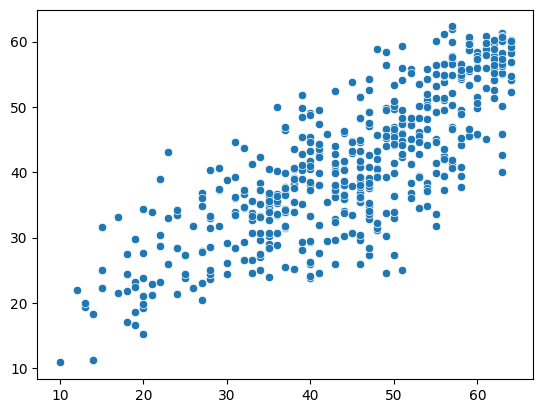

In [185]:
sns.scatterplot(y = y_pred, x = y.values)

# Estimating the effects of impact

Veteran serving organizations care deeply about my well being?
Average Hope Scale Score Impact Due to intervention: -16.14% (±-3.76%) Increase For 11% Of Service Men And Women
(-5.57±-1.3 raw average, -284±-66 raw overall)

Community is involved with veterans?
Average Hope Scale Score Impact Due to intervention: -12.9% (±-2.83%) Increase For 13% Of Service Men And Women
(-4.0±-0.88 raw average, -162±-35 raw overall)

Has Dependable Support?
Average Hope Scale Score Impact Due to intervention: -13.83% (±-3.46%) Increase For 14% Of Service Men And Women
(-4.7±-1.18 raw average, -92±-23 raw overall)

Owns a car?
Average Hope Scale Score Impact Due to intervention: -6.13% (±-1.04%) Increase For 30% Of Service Men And Women
(-2.51±-0.43 raw average, -253±-43 raw overall)



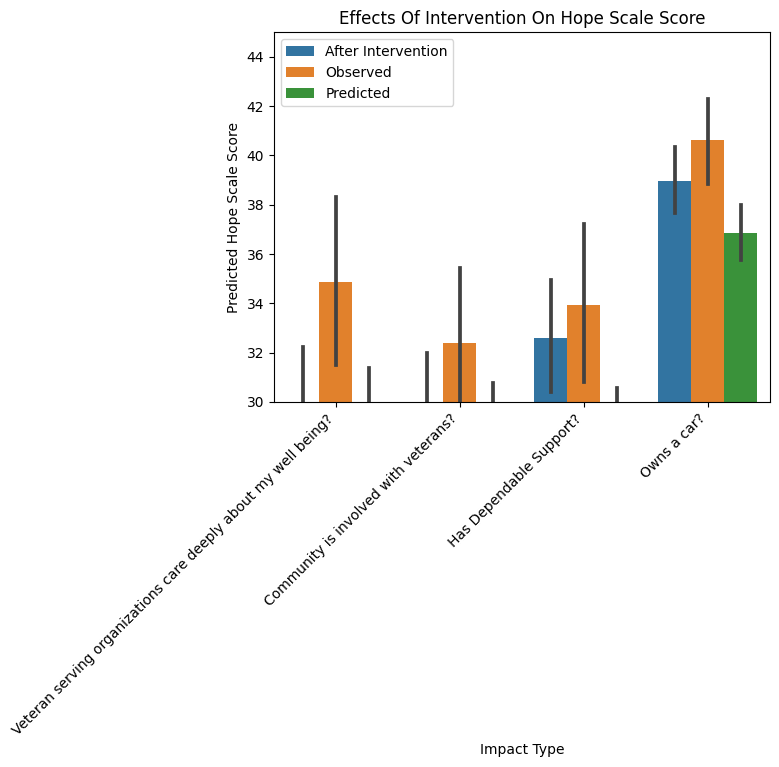

In [187]:
x2 = x.copy()
x2[scale_columns] = x_scaler.transform(x2[scale_columns])
x2.values[x2.values>5] = 5
x2.values[x2.values<-5] = -5
x2 = x2.values
predicted = []
predicted_with_intervention = []
df_plots = []
for impact_column in impact_columns:
    
    x3 = x.copy()
    x3[impact_column] = impact_columns[impact_column]

    x3[scale_columns] = x_scaler.transform(x3[scale_columns])
    x3[x3>5] = 5
    x3[x3<-5] = -5
    x3 = x3.values
    noeq_index = (x3[:, predictors.index(impact_column)] 
                  != x2[:, predictors.index(impact_column)])
    x_Observed = x2[noeq_index]
    x_Speculated = x3[noeq_index]
    if len(x_Observed) == 0:
        continue
    y_pred = model.predict(x_Observed)
    y_pred2 = model.predict(x_Speculated)
    y_observed = y.values[noeq_index]
    diff = y_pred2-y_pred
    #diff = y_pred2-y_observed
    y_pred = y_pred[diff>0]
    y_pred2 = y_pred2[diff>0]
    y_observed = y_observed[diff>0]
    #y_observed = y.values[noeq_index]
    y_mn = np.median(y_observed)
    y_mn2 = np.median(y_pred2)
    mean_error, std_error = getMeanErrorStats(y_observed, y_pred, samples = 1000, sample_elements = 25)
    error = mean_error + 2*std_error
    relative_increase = round((100 * (y_mn2 - y_mn)/y_mn), 2)
    rel_error = round(relative_increase*error,2)
    net_overall_increase = int(round(np.sum((y_pred2 - y_observed))))
    net_err = int(round(net_overall_increase*error))
    absolute_average_increase = round(y_mn2 - y_mn, 2)
    absolute_err = round(absolute_average_increase*error, 2)
    percent_afflicted = round(100 * len(y_observed)/len(x))
    print(impact_column)
    print(f"Average Hope Scale Score Impact Due to intervention: {relative_increase}% (" u"\u00B1" + f"{rel_error}%) Increase For {percent_afflicted}% Of Service Men And Women")
    print(f"({absolute_average_increase}" + u"\u00B1" + f"{absolute_err} raw average, {net_overall_increase}" + u"\u00B1" + f"{net_err} raw overall)")
    print()
    df_plot = pd.DataFrame({'Hope Scale Score': (3 * [z for z in y_observed]),
                           'Predicted Hope Scale Score' : ([z for z in y_pred2] + [z for z in y_observed] +
                                                          [z for z in y_pred]),
                            'id' : (3 * [i for i in range(len(y_observed))]),
                           'With Intervention' : (['After Intervention' for x in y_pred2] + 
                                                  ['Observed' for x in y_observed] +
                                                 ['Predicted' for x in y_observed]),
                          'Impact Type' : 3 * [impact_column for z in y_observed]})
    predicted.append(y_mn)
    predicted_with_intervention.append(y_mn2)
    #ax = sns.lmplot(data = df_plot, x = 'Hope Scale Score', y = 'Predicted Hope Scale Score', hue = 'With Intervention', scatter = False)
    #plt.show()
    df_plots.append(df_plot)
df_plot2 = pd.concat(df_plots, ignore_index = True)

csv_path = os.path.join("..", "Data", "Results.csv")
df_plot2.to_csv(csv_path, index = False)
ax = sns.barplot(data = df_plot2, y = 'Predicted Hope Scale Score', x = "Impact Type", hue = 'With Intervention')
ax.legend(title=None)
ax.set(ylim = (30, 45), title = "Effects Of Intervention On Hope Scale Score")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

# Verify With Linear Model

In [188]:
model_lr = LinearRegression()
x2 = x.copy()
x2[scale_columns] = x_scaler.transform(x2[scale_columns])
for col in scale_columns:
    None
    x2[col] = x2[col].apply(min, args = [4])
    x2[col] = x2[col].apply(max, args = [-4])
model_lr.fit(X2, Y)
model_lr.score(x2, y)
y_pred_lr = model_lr.predict(x2)

In [189]:
pred_mre = round(MRE(y_pred_lr, y.values), 3)
mre_scores = []
y_pred_hyp = y_pred_lr.copy()
for _ in range(1000):
    np.random.shuffle(y_pred_hyp)
    mre_scores.append(MRE(y_pred_hyp, y.values))
mn = np.mean(mre_scores)
sd = np.std(mre_scores)
alpha = norm.cdf(pred_mre, loc = mn, scale = sd)
print("Mean Relative Error", pred_mre)
print("Mean Relative Error Alpha", alpha)

Mean Relative Error 0.204
Mean Relative Error Alpha 3.134236220975928e-54


In [190]:
pd.DataFrame({'pred' : y_pred_lr, "ob" : y.values}).corr()

,pred,ob
pred,1.000000,0.752611
ob,0.752611,1.000000


<AxesSubplot: >

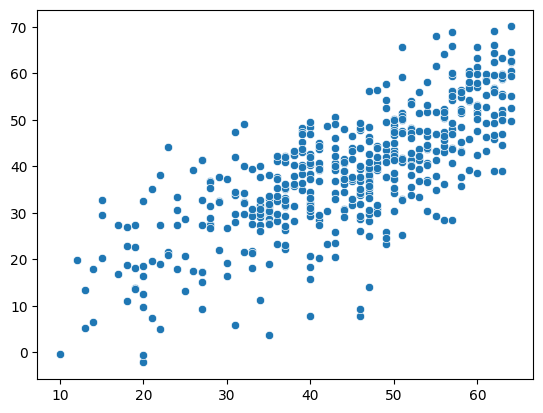

In [191]:
sns.scatterplot(y = y_pred_lr, x = y.values)

K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
K:\Anaconda\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  w

Community is involved with veterans?
Average Hope Scale Score Impact Due to intervention: -22.82% (±-10.94%) Increase For 20% Of Service Men And Women
(-8.08±-3.87 raw average, -832±-399 raw overall)

Has Dependable Support?
Average Hope Scale Score Impact Due to intervention: -24.66% (±-13.48%) Increase For 16% Of Service Men And Women
(-8.56±-4.68 raw average, -710±-388 raw overall)



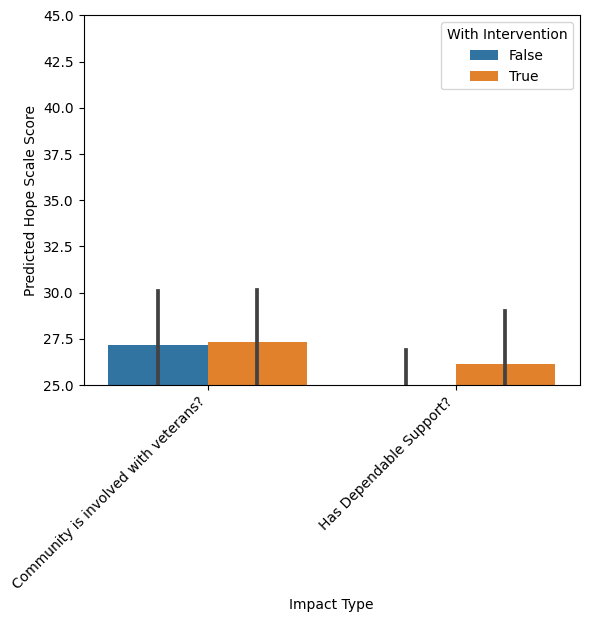

In [192]:
x2 = x.copy()
x2[scale_columns] = x_scaler.transform(x2[scale_columns])
x2 = x2.values
predicted = []
predicted_with_intervention = []
df_plots = []
for impact_column in impact_columns:
    
    x3 = x.copy()
    x3[impact_column] = impact_columns[impact_column]

    x3[scale_columns] = x_scaler.transform(x3[scale_columns])
    x3 = x3.values
    noeq_index = (x3[:, predictors.index(impact_column)] 
                  != x2[:, predictors.index(impact_column)])
    x_Observed = x2[noeq_index]
    x_Speculated = x3[noeq_index]
    if len(x_Observed) == 0 or len(x_Speculated) == 0:
        continue
    y_pred = model_lr.predict(x_Observed)
    y_pred2 = model_lr.predict(x_Speculated)
    diff = y_pred2-y_pred
    y_pred = y_pred[diff>0]
    if len(y_pred) == 0:
        continue
    y_pred2 = y_pred2[diff>0]
    y_observed = y.values[noeq_index][diff>0]
    y_mn = np.mean(y_observed)
    y_mn2 = np.mean(y_pred2)
    mean_error, std_error = getMeanErrorStats(y_observed, y_pred, samples = 1000, sample_elements = 25)
    error = mean_error + 4*std_error
    relative_increase = round((100 * (y_mn2 - y_mn)/y_mn), 2)
    rel_error = round(relative_increase*error,2)
    net_overall_increase = int(round(np.sum((y_pred2 - y_observed))))
    net_err = int(round(net_overall_increase*error))
    absolute_average_increase = round(y_mn2 - y_mn, 2)
    absolute_err = round(absolute_average_increase*error, 2)
    percent_afflicted = round(100 * len(y_observed)/len(x))
    print(impact_column)
    print(f"Average Hope Scale Score Impact Due to intervention: {relative_increase}% (" u"\u00B1" + f"{rel_error}%) Increase For {percent_afflicted}% Of Service Men And Women")
    print(f"({absolute_average_increase}" + u"\u00B1" + f"{absolute_err} raw average, {net_overall_increase}" + u"\u00B1" + f"{net_err} raw overall)")
    print()
    df_plot = pd.DataFrame({'Hope Scale Score': (2 * [z for z in y_observed]),
                           'Predicted Hope Scale Score' : [z for z in y_pred] + [z for z in y_pred2],
                           'With Intervention' : [False for x in y_pred] + [True for x in y_pred2],
                          'Impact Type' : 2 * [impact_column for z in y_observed]})
    predicted.append(y_mn)
    predicted_with_intervention.append(y_mn2)
    #ax = sns.lmplot(data = df_plot, x = 'Hope Scale Score', y = 'Predicted Hope Scale Score', hue = 'With Intervention', scatter = False)
    #plt.show()
    df_plots.append(df_plot)
df_plot2 = pd.concat(df_plots, ignore_index = True)
ax = sns.barplot(data = df_plot2, y = 'Predicted Hope Scale Score', x = "Impact Type", hue = 'With Intervention')
ax.set(ylim = (25, 45))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

In [ ]:
model_path = os.path.join("..", "Models", "Linear.model")
with open(model_path, "wb") as f:
    pickle.dump(model_lr, f)

# DecisionTree Layout

In [ ]:
import copy
DT_model = GridSearchCV(DecisionTreeRegressor(), param_grid = {
    "criterion" : ["squared_error", "friedman_mse", "absolute_error", "poisson"],
    "splitter" : ["best", "random"],
    "max_depth" : [None, 2, 5, 10, 15, 20, 25],
    "random_state" : [42]
})
X3 = copy.copy(X2)
X3[pd.isna(X3)] = 0
DT_model.fit(X3, Y)

In [ ]:
x2 = x.copy()
x2[scale_columns] = x_scaler.transform(x2[scale_columns])
fig = plt.figure(figsize  = (10*18,10*12))
plt_tree = plot_tree(DT_model.best_estimator_, 
              feature_names = [resize(col.split(':')[0]) for col in X2.columns], 
              filled = True,
             max_depth = 2)
plt.savefig('plots_2022/DescisionTree_3.png')

In [ ]:
DT_model.score(x2,y)

In [ ]:
y_pred = DT_model.predict(x2)
sns.scatterplot(y = y_pred,
                x = y.values)

In [ ]:
pd.DataFrame({"prediction" : y_pred, 
              "observation"  : y.values}).corr()

In [ ]:
model_path = os.path.join("..", "Models", "DescisionTree.model")
with open(model_path, "wb") as f:
    pickle.dump(DT_model, f)